# Solution of the Griewangk Problem in use of Genetic Algorithm

The **Griewangk** Problem is a minimization problem.

Formally, this problem can be described as finding an string
$\vec{x}=\{x_{1},x_{2},\ldots{},x_{N}\}$, with $x_{i}\in (-600,
600)$, that minimizes the following equation:

\begin{equation}
    \mathop{F(\vec{x})}= 1 + \sum\limits_{i = 1}^n \frac{x_{i}^{2}}{4000}
    - \prod\limits_{i = 1}^n cos(\frac{x_{i}}{\sqrt{i}})
\end{equation}


In [76]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

** Griewank Function二维示意图**

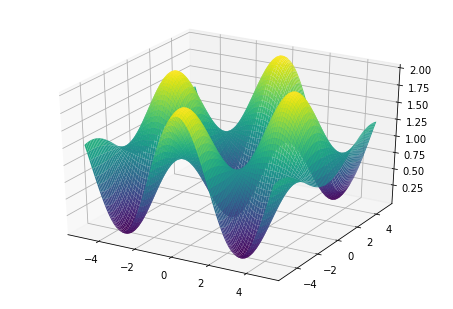

In [81]:
x = np.arange(-5,5,0.12)
X,Y = np.meshgrid(x,x)
Z = 1 / 4000 * (X ** 2 + Y ** 2) - np.cos(X)*np.cos(Y / np.sqrt(2)) + 1
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.viridis)

In [63]:
def grieFunc(vardim, x):
    """
    Griewangk function
    输入
    varDim: int, 输入变量的维度
    x: ndarray, 输入变量
    输出：
    y: fitness
    """
    y = 1. / 4000 * np.sum(np.square(x)) - np.cumprod(np.cos(x / np.sqrt(range(1, vardim + 1))))[-1] + 1
    y = 1. / (1. + y)
    return y

In [64]:
class gaIndividual:
    '''
    individual of genetic algorithm
    '''
    def __init__(self, variableDimension, boudaries):
        self.vardim = variableDimension
        self.bound = boudaries
        self.fitness = 0.

    def generate(self):
        '''
        generate a random chromsome for genetic algorithm
        为遗传算法生成一个随机染色体
        '''
        len = self.vardim
        rnd = np.random.random(size = len)
        self.chrom = np.zeros(len)
        for i in range(0, len):
            self.chrom[i] = self.bound[0, i]+(self.bound[1,i]-self.bound[0,i]*rnd[i])
    
    def calculateFitness(self):
        '''
        calculate the fitness of the chromsome
        计算染色体的适应性
        '''
        self.fitness = grieFunc(self.vardim, self.chrom)

In [65]:
class geneticAlgorithm:
    '''
    The class for genetic algorithm
    '''
    def __init__(self, populationSize, variablesDimension, boundaries, maxGen, params):
        '''
        populationSize:  种群数量 60
        variablesDimension:  变量维度 25
        boundaries: boundaries of variables 变量的边界 -600 600
        maxGen: termination condition  终止条件  1000
        params: algorithm required parameters, it is a list which is consisting of crossover rate, mutation rate, alpha
        算法所需的参数，它是由交叉率，变异率，alpha组成的列表
        0.9, 0.1, 0.5
        '''
        self.popSize = populationSize
        self.MAXGEN = maxGen
        self.vardim = variablesDimension
        self.bound = boundaries
        self.params = params
        self.population = []
        self.fitness = np.zeros((self.popSize, 1))
        self.trace = np.zeros((self.MAXGEN, 2))

    def initialize(self):
        '''
        initialize the population 初始化种群
        '''
        for i in range(0, self.popSize):
            ind = gaIndividual(self.vardim, self.bound)
            ind.generate()
            self.population.append(ind)
    
    def evaluate(self):
        '''
        evaluation of the population fitnesses
        评估种群适合度
        '''
        for i in range(0, self.popSize):
            self.population[i].calculateFitness()
            self.fitness[i] = self.population[i].fitness
    def solve(self):
        '''
        evolution process of genetic algorithm
        遗传算法的演化过程
        '''
        self.t = 0
        self.initialize()
        self.evaluate()
        best = np.max(self.fitness)
        bestIndex = np.argmax(self.fitness)
        self.best = copy.deepcopy(self.population[bestIndex])

        self.averageFitneess = np.mean(self.fitness)
        self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
        self.trace[self.t, 1] = (1 - self.averageFitneess) / self.averageFitneess
        print("Generation  %d: optimal function value is: %f; average function value is %f" % (self.t, self.trace[self.t, 0], self.trace[self.t, 1]))
        
        while (self.t < self.MAXGEN - 1): 
            self.t += 1 
            self.selectionOperation() 
            self.crossoverOperation() 
            self.mutationOperation() 
            self.evaluate() 
            best = np.max(self.fitness) 
            bestIndex = np.argmax(self.fitness) 
            if best > self.best.fitness: 
                self.best = copy.deepcopy(self.population[bestIndex]) 
                self.averageFitneess = np.mean(self.fitness)
                self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
                self.trace[self.t, 1] = (1 - self.averageFitneess) / self.averageFitneess
            # print("Generation %d: optimal function value is: %f; average function value is %f" % ( self.t, self.trace[self.t, 0], self.trace[self.t, 1]))
        print("Optimal function value is: %f; " % self.trace[self.t, 0]) 
        print ("Optimal solution is:") 
        print (self.best.chrom) 
        self.printResult()
        
    def selectionOperation(self):
        '''
        selection operation for Genetic Algorithm
        遗传算法的选择操作
        '''
        newPopulation = []
        totalFitness = np.sum(self.fitness)
        accuFitness = np.zeros((self.popSize, 1))

        accuFitness = np.cumsum(self.fitness) / totalFitness
        
        for i in range(0, self.popSize):
            r = np.random.random()
            idx = 0
            for j in range(0, self.popSize-1):
                if j == 0 and r < accuFitness[j]:
                    idx = 0
                    break
                elif r >=accuFitness[j] and r < accuFitness[j + 1]:
                    idx = j + 1
                    break
            newPopulation.append(self.population[idx])
        self.population = newPopulation
    
    def crossoverOperation(self):
        '''
        crossover operation for genetic algorithm
        交叉操作
        '''
        newPopulation = []
        for i in range(0, self.popSize, 2):
            idx1 = np.random.randint(0, self.popSize - 1)
            idx2 = np.random.randint(0, self.popSize - 1)
            while idx1 == idx2:
                idx2 = np.random.randint(0, self.popSize - 1)
            newPopulation.append(copy.deepcopy(self.population[idx1]))
            newPopulation.append(copy.deepcopy(self.population[idx2]))
            r = np.random.random()
            if r < self.params[0]:
                crossPos = np.random.randint(1, self.vardim-1)
                for j in range(crossPos, self.vardim):
                    newPopulation[i].chrom[j] = newPopulation[i].chrom[j]*self.params[2]+(1-self.params[2])*newPopulation[i+1].chrom[j]
                    newPopulation[i+1].chrom[j] = newPopulation[i+1].chrom[j]*self.params[2]+(1-self.params[2])*newPopulation[i].chrom[j]
        self.population = newPopulation

    def mutationOperation(self):
        '''
        mutation operation for genetic algorithm
        变异操作。
        '''
        newPopulation = []
        for i in range(0, self.popSize):
            newPopulation.append(copy.deepcopy(self.population[i]))
            r = np.random.random()
            if r < self.params[1]:
                mutatePos = np.random.randint(0, self.vardim-1)
                theta = np.random.random()
                if theta > 0.5:
                    newPopulation[i].chrom[mutatePos] = newPopulation[i].chrom[mutatePos] - (newPopulation[i].chrom[mutatePos] - self.bound[0,mutatePos]) * (1 - np.random.random() * (1- self.t/self.MAXGEN)**2)
                else:
                    newPopulation[i].chrom[mutatePos] = newPopulation[i].chrom[mutatePos] - (self.bound[1, mutatePos] - newPopulation[i].chrom[mutatePos])* (1 - np.random.random() *(1 - self.t / self.MAXGEN)**2)

        self.population = newPopulation
    
    def printResult(self): 
        '''
        plot the result of the genetic algorithm
        画出结果
        ''' 
        plt.close()
        x = np.arange(0, self.MAXGEN) 
        labels = ["optimal value", "average avlue"]
        
        fig, axes = plt.subplots(2,1, figsize=(8,6),sharey=True)
        
        for i in range(2):
            axes[i].plot(x, self.trace[:,i], 'r', label=labels[i]) 
            axes[i].legend(loc='best')
        plt.subplots_adjust(wspace=0,hspace=0)
#         plt.savefig('GA_iteration1.png', dpi=400, bbox_inches='tight')

Generation  0: optimal function value is: 452.576403; average function value is 728.322567
Optimal function value is: 0.000000; 
Optimal solution is:
[  56.1051364    66.7045112   152.85945562  -55.83387688   11.48164255
   33.65879775  -44.59389403   50.76894519    2.28135917   56.31978762
  -55.83255334 -165.15320763  -41.20163444 -130.16845721  -15.63470315
 -120.07596891  -13.99920691   -5.56393781 -113.9707765   -35.80425312
  -23.20431126  -90.24916421  -51.02518798 -136.79671249  258.02723759]


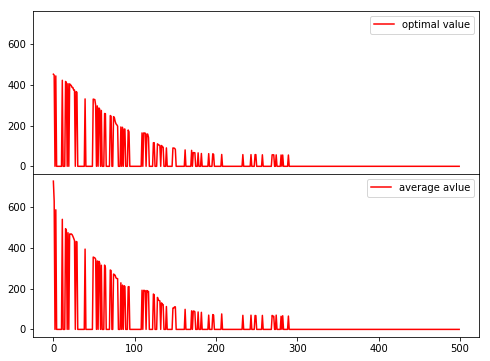

In [66]:
boundaries = np.tile([[-600],[600]],25)
ga = geneticAlgorithm(60, 25, boundaries, 500, [0.9, 0.1, 0.5])
ga.solve()